# Previsão de produtos cosméticos

## Sistema de previsão de produtos cosméticos para tratamentos estéticos

### Contexto

Esse notebook contém os passos necessários para gerar um modelo de machine learning capaz de indicar produtos cosméticos para tratamentos estéticos.

Esse notebook faz parte do **Projeto Aplicado** da Pós-Graduação de Data Science e Machine Learning com Inteligência Artificial.

## Configurações do ambiente

In [1]:
from platform import python_version
print('Language Python vesrion used in this notebook is: ', python_version())

Language Python vesrion used in this notebook is:  3.10.15


In [2]:
!ls -la ../

total 16
drwxr-xr-x   8 tom  staff  256 Dec  8 14:10 .
drwxr-xr-x@ 15 tom  staff  480 Dec  8 14:10 ..
drwxr-xr-x   8 tom  staff  256 Nov 19 21:47 api
drwxr-xr-x  12 tom  staff  384 Nov 24 21:55 api_sppc
drwxr-xr-x@ 13 tom  staff  416 Dec  8 12:28 auxiliar
-rw-r--r--   1 tom  staff    0 Nov 19 21:47 db.sqlite3
-rwxr-xr-x   1 tom  staff  659 Nov 18 20:43 manage.py
-rw-r--r--   1 tom  staff  277 Dec  8 16:59 requirements.txt


## Carregando as bibliotecas

In [3]:
import pandas as pd
import numpy as np
import psycopg2 as ps
import os
from dotenv import load_dotenv
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    r2_score,
    mean_squared_error
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.sparse import csr_matrix

## Carregando datasets

### Criando conexão com o banco de dados PostgreSql

In [6]:
load_dotenv(dotenv_path="../dotenv_files/.env")
conn = ps.connect(
    database=os.getenv("POSTGRES_DB"),
    user=os.getenv("POSTGRES_USER"),
    host="localhost",
    password=os.getenv("POSTGRES_PASSWORD"),
    port=os.getenv("POSTGRES_PORT"),
)

cs = conn.cursor()

OperationalError: connection to server at "localhost" (::1), port 5432 failed: fe_sendauth: no password supplied


In [7]:
if conn.closed == 0:
    print("A conexão está aberta.")
else:
    print("A conexão está fechada ou perdida.")

NameError: name 'conn' is not defined

### Criando os dataframes

Consumidores

In [ ]:
try:
    cs.execute(query="select * from sppc_db.public.api_sppc_consumidor;")
    result = cs.fetchall()
    df_consumidores = pd.DataFrame(data=result, columns=[desc[0] for desc in cs.description])
    df_consumidores = df_consumidores.replace({None: np.nan})
    print("Consulta realizada com sucesso.")
    display(df_consumidores.head())
except Exception as e:
    print("Alguma coisa ruim aconteceu enquanto consultava a tabela: ", e)

Consulta realizada com sucesso.


,id,nome,data_nascimento,profissao,fumante,disturbio_circulatorio,epiletico,ciclo_intestinal_regular,funcionamento_intestinal_regular,alteracao_cardiaca,...,braco_esquerdo,braco_direito,abdomen,cintura,quadril,culote,coxa_esquerda,coxa_direita,panturrilha_esquerda,panturrilha_direita
0,5,Teste 1,1990-11-25,Pedreiro,False,False,False,False,False,True,...,40.0000,35.0000,90.0000,90.0000,90.0000,4.0000,40.0000,40.0000,30.0000,30.0000
1,6,Boy,2022-02-28,Careers adviser,True,False,True,False,False,False,...,44.0000,31.0000,90.0000,107.0000,168.0000,3.0000,49.0000,58.0000,15.0000,38.0000
2,7,Citizen attention,2011-05-12,Herbalist,True,True,True,True,False,False,...,23.0000,44.0000,68.0000,70.0000,161.0000,5.0000,44.0000,50.0000,58.0000,56.0000
3,8,Program,1990-11-29,Counselling psychologist,False,True,False,False,True,True,...,44.0000,39.0000,85.0000,110.0000,181.0000,6.0000,48.0000,32.0000,32.0000,37.0000
4,9,Glass,1995-06-01,Production manager,True,False,False,False,False,True,...,43.0000,37.0000,98.0000,88.0000,167.0000,9.0000,41.0000,43.0000,56.0000,28.0000


Tratamentos

In [ ]:
try:
    cs.execute(query="select * from sppc_db.public.api_sppc_tratamento;")
    result = cs.fetchall()
    df_tratamentos = pd.DataFrame(data=result, columns=[desc[0] for desc in cs.description])
    df_tratamentos = df_tratamentos.replace({None: np.nan})
    print("Consulta realizada com sucesso.")
    display(df_tratamentos.head())
except Exception as e:
    print("Alguma coisa ruim aconteceu enquanto consultava a tabela: ", e)

Consulta realizada com sucesso.


,id,descricao,data_inicio,data_fim,peso_inicial,peso_final,eficaz,consumidores_id
0,4,Limpeza de pele,2024-11-24,NaN,89.0000,NaN,NaN,5
1,5,Yard,2024-12-28,2025-02-26,85.0000,83.0000,False,39
2,6,Eight,2023-11-09,2023-12-31,82.0000,81.0000,False,55
3,7,Laugh,2023-08-05,2023-10-08,62.0000,60.0000,True,46
4,8,Reveal agent,2024-02-08,2024-04-06,90.0000,84.0000,True,26


Produtos dos tratamentos

In [ ]:
try:
    cs.execute(query="select * from sppc_db.public.api_sppc_tratamento_produtos;")
    result = cs.fetchall()
    df_tratamentos_produtos = pd.DataFrame(data=result, columns=[desc[0] for desc in cs.description])
    df_tratamentos_produtos = df_tratamentos_produtos.replace({None: np.nan})
    print("Consulta realizada com sucesso.")
    display(df_tratamentos_produtos.head())
except Exception as e:
    print("Alguma coisa ruim aconteceu enquanto consultava a tabela: ", e)

Consulta realizada com sucesso.


,id,tratamento_id,produto_id
0,1,4,3
1,2,4,4
2,3,5,13
3,4,6,5
4,5,6,14


In [ ]:
conn.close()

In [ ]:
del conn, cs, result

## Análise de dados exploratória

### Análise geral dos dados

In [6]:
def data_overview(df: pd.DataFrame()):
  print(f"> Head\n{df.head(n=5)}", end="\n\n\n")
  print(f"> Info\n{df.info()}", end="\n\n\n")
  print(f"> Shape\n{df.shape}", end="\n\n\n")
  print(f"> Is NAN\n{df.isna().sum()}", end="\n\n\n")
  print(f"> Is null\n{df.isnull().sum()}", end="\n\n\n")
  print(f"> Describe\n{df.describe()}", end="\n\n\n")

In [7]:
data_overview(df=df_consumidores)

NameError: name 'df_consumidores' is not defined

⚠ Note que a variável "data_nascimento" está como string, mas seria melhor que estivesse como date.

⚠ Note que as variáveis "altura", "peso", "busto", "braco_esquerdo", "braco_direito", "abdomen", "cintura", "quadril", "culote", "coxa_esquerda", "coxa_direita", "panturrilha_esquerda" e "panturrilha_direita" estão como string, mas seria melhor que estivessem como float.

In [ ]:
data_overview(df=df_tratamentos)

> Head
   id        descricao data_inicio    data_fim peso_inicial peso_final eficaz  \
0   4  Limpeza de pele  2024-11-24         NaN      89.0000        NaN    NaN   
1   5             Yard  2024-12-28  2025-02-26      85.0000    83.0000  False   
2   6            Eight  2023-11-09  2023-12-31      82.0000    81.0000  False   
3   7            Laugh  2023-08-05  2023-10-08      62.0000    60.0000   True   
4   8     Reveal agent  2024-02-08  2024-04-06      90.0000    84.0000   True   

   consumidores_id  
0                5  
1               39  
2               55  
3               46  
4               26  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               2001 non-null   int64 
 1   descricao        2001 non-null   object
 2   data_inicio      2001 non-null   object
 3   data_fim         2000 non-null   object
 4

⚠ Note que as variáves "data_inicio" e "data_fim" estão como string, mas seria melhor que estivessem como date.

⚠ Note que as variáveis "peso_inicial" e "peso_final" estão como string, mas seria melhor que estivessem como float.

⚠ Note que há um  tratamento que não possui data fim, suponhamos que o tratamento ainda não foi finalizado. Avaliar e se o tratamento ainda não teve fim, se tratando de uma única observação, podemos remove-la.

In [ ]:
data_overview(df=df_tratamentos_produtos)

> Head
   id  tratamento_id  produto_id
0   1              4           3
1   2              4           4
2   3              5          13
3   4              6           5
4   5              6          14


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3815 entries, 0 to 3814
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   id             3815 non-null   int64
 1   tratamento_id  3815 non-null   int64
 2   produto_id     3815 non-null   int64
dtypes: int64(3)
memory usage: 89.5 KB
> Info
None


> Shape
(3815, 3)


> Is NAN
id               0
tratamento_id    0
produto_id       0
dtype: int64


> Is null
id               0
tratamento_id    0
produto_id       0
dtype: int64


> Describe
                id  tratamento_id   produto_id
count  3815.000000    3815.000000  3815.000000
mean   1908.000000    1002.518218    11.103801
std    1101.439967     578.447559     4.950804
min       1.000000       4.000000     3.00

### Limpeza dos dados

In [ ]:
df_tratamentos.loc[df_tratamentos["data_fim"].isna()]

,id,descricao,data_inicio,data_fim,peso_inicial,peso_final,eficaz,consumidores_id
0,4,Limpeza de pele,2024-11-24,NaN,89.0000,NaN,NaN,5


In [ ]:
df_tratamentos.loc[df_tratamentos["data_fim"].isnull()]

,id,descricao,data_inicio,data_fim,peso_inicial,peso_final,eficaz,consumidores_id
0,4,Limpeza de pele,2024-11-24,NaN,89.0000,NaN,NaN,5


In [ ]:
df_tratamentos.dropna(how="all", subset=["data_fim"], inplace=True)

In [ ]:
df_tratamentos.isna().sum()

id                 0
descricao          0
data_inicio        0
data_fim           0
peso_inicial       0
peso_final         0
eficaz             0
consumidores_id    0
dtype: int64

### Manipulação dos dados

In [ ]:
df_consumidores = df_consumidores.astype(dtype={
    "data_nascimento": "datetime64[ms]",
    "altura": np.float64, 
    "peso": np.float64, 
    "busto": np.float64, 
    "braco_esquerdo": np.float64, 
    "braco_direito": np.float64, 
    "abdomen": np.float64, 
    "cintura": np.float64, 
    "quadril": np.float64, 
    "culote": np.float64, 
    "coxa_esquerda": np.float64, 
    "coxa_direita": np.float64, 
    "panturrilha_esquerda": np.float64,
    "panturrilha_direita": np.float64
})

In [ ]:
df_consumidores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 51 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                51 non-null     int64         
 1   nome                              51 non-null     object        
 2   data_nascimento                   51 non-null     datetime64[ms]
 3   profissao                         51 non-null     object        
 4   fumante                           51 non-null     bool          
 5   disturbio_circulatorio            51 non-null     bool          
 6   epiletico                         51 non-null     bool          
 7   ciclo_intestinal_regular          51 non-null     bool          
 8   funcionamento_intestinal_regular  51 non-null     bool          
 9   alteracao_cardiaca                51 non-null     bool          
 10  disturbio_hormonal                51 non-null     bo

In [ ]:
df_consumidores.head(n=3)

,id,nome,data_nascimento,profissao,fumante,disturbio_circulatorio,epiletico,ciclo_intestinal_regular,funcionamento_intestinal_regular,alteracao_cardiaca,...,braco_esquerdo,braco_direito,abdomen,cintura,quadril,culote,coxa_esquerda,coxa_direita,panturrilha_esquerda,panturrilha_direita
0,5,Teste 1,1990-11-25,Pedreiro,False,False,False,False,False,True,...,40.0,35.0,90.0,90.0,90.0,4.0,40.0,40.0,30.0,30.0
1,6,Boy,2022-02-28,Careers adviser,True,False,True,False,False,False,...,44.0,31.0,90.0,107.0,168.0,3.0,49.0,58.0,15.0,38.0
2,7,Citizen attention,2011-05-12,Herbalist,True,True,True,True,False,False,...,23.0,44.0,68.0,70.0,161.0,5.0,44.0,50.0,58.0,56.0


In [ ]:
df_tratamentos = df_tratamentos.astype(dtype={
    "data_inicio": "datetime64[ms]",
    "data_fim": "datetime64[ms]",
    "peso_inicial": np.float64,
    "peso_final": np.float64
})

In [ ]:
df_tratamentos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 1 to 2000
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               2000 non-null   int64         
 1   descricao        2000 non-null   object        
 2   data_inicio      2000 non-null   datetime64[ms]
 3   data_fim         2000 non-null   datetime64[ms]
 4   peso_inicial     2000 non-null   float64       
 5   peso_final       2000 non-null   float64       
 6   eficaz           2000 non-null   object        
 7   consumidores_id  2000 non-null   int64         
dtypes: datetime64[ms](2), float64(2), int64(2), object(2)
memory usage: 140.6+ KB


### Visualização dos dados

## Feature engineering

Criando a idade do consumidor

In [8]:
df_consumidores["idade"] = df_consumidores["data_nascimento"].apply(func=(lambda x: (datetime.now().year - x.year)))
df_consumidores["idade"].head()

NameError: name 'df_consumidores' is not defined

Criando o IMC do consumidor

In [ ]:
df_consumidores[["peso", "altura"]].head()

,peso,altura
0,90.0,190.0
1,102.0,205.0
2,108.0,182.0
3,63.0,196.0
4,110.0,200.0


In [ ]:
df_consumidores["imc"] = np.divide(
    df_consumidores["peso"], 
    np.square(
        np.divide(df_consumidores["altura"], 100), 
        np.divide(df_consumidores["altura"], 100)
        )
    )

In [ ]:
df_consumidores["imc"].head()

0    24.930748
1    24.271267
2    32.604758
3    16.399417
4    27.500000
Name: imc, dtype: float64

Criando dias de tratamento

In [ ]:
df_tratamentos["dias_tratamento"] = (df_tratamentos["data_fim"] - df_tratamentos["data_inicio"]).dt.days
df_tratamentos["dias_tratamento"].head()

1    60
2    52
3    64
4    58
5    71
Name: dias_tratamento, dtype: int64

Criando quantidade ganha ou perdida de peso

In [ ]:
df_tratamentos["ganho_perda_peso"] = (df_tratamentos["peso_final"] - df_tratamentos["peso_inicial"])

## Pré-processamento

### Pré-processamento 1

Unindo os datasets

In [133]:
df_to_model = pd.merge(
    left=df_tratamentos,
    right=df_consumidores,
    how="inner",
    left_on="consumidores_id",
    right_on="id",
    suffixes=("_tratamento", "_consumidor")
)
df_to_model.head()

,id_tratamento,descricao,data_inicio,data_fim,peso_inicial,peso_final,eficaz,consumidores_id,dias_tratamento,ganho_perda_peso,...,abdomen,cintura,quadril,culote,coxa_esquerda,coxa_direita,panturrilha_esquerda,panturrilha_direita,idade,imc
0,5,Yard,2024-12-28,2025-02-26,85.0,83.0,False,39,60,-2.0,...,169.0,135.0,78.0,7.0,31.0,44.0,43.0,47.0,29,46.826223
1,6,Eight,2023-11-09,2023-12-31,82.0,81.0,False,55,52,-1.0,...,123.0,63.0,149.0,2.0,49.0,49.0,38.0,22.0,5,17.158054
2,7,Laugh,2023-08-05,2023-10-08,62.0,60.0,True,46,64,-2.0,...,147.0,142.0,61.0,9.0,32.0,59.0,59.0,36.0,3,32.987916
3,8,Reveal agent,2024-02-08,2024-04-06,90.0,84.0,True,26,58,-6.0,...,163.0,120.0,74.0,4.0,46.0,30.0,26.0,50.0,0,22.675153
4,9,Film,2024-09-03,2024-11-13,75.0,73.0,False,26,71,-2.0,...,163.0,120.0,74.0,4.0,46.0,30.0,26.0,50.0,0,22.675153


In [134]:
df_to_model = pd.merge(
    left=df_to_model,
    right=df_tratamentos_produtos,
    how="inner",
    left_on="id_tratamento",
    right_on="tratamento_id",
    suffixes=("_tratamento", "_produto")
)

In [135]:
df_to_model.columns

Index(['id_tratamento', 'descricao', 'data_inicio', 'data_fim', 'peso_inicial',
       'peso_final', 'eficaz', 'consumidores_id', 'dias_tratamento',
       'ganho_perda_peso', 'id_consumidor', 'nome', 'data_nascimento',
       'profissao', 'fumante', 'disturbio_circulatorio', 'epiletico',
       'ciclo_intestinal_regular', 'funcionamento_intestinal_regular',
       'alteracao_cardiaca', 'disturbio_hormonal', 'hipotensao', 'hipertensao',
       'disturbio_renal', 'varizes_lesoes', 'diabetes', 'tipo_diabetes',
       'diabetes_controlada', 'tratamento_medico', 'detalhe_tratamento_medico',
       'cirurgia_recente', 'detalhe_cirurgia_recente', 'problema_pele',
       'detalhe_problema_pele', 'protese_corporal_facial',
       'detalhe_protese_corporal_facial', 'gestante', 'semanas_gestante',
       'alergia', 'detalhe_alergia', 'tumor_lesao_precancerosa',
       'detalhe_tumor_lesao_precancerosa', 'ortopedico', 'detalhe_ortopedico',
       'acido', 'detalhe_acido', 'outro_problema', 'detal

Removendo colunas não necessárias

In [136]:
df_to_model.drop(
    columns=[
        "data_nascimento",
        "peso",
        "altura",
        "data_inicio",
        "data_fim",
        "peso_inicial",
        "peso_final",
        "id_tratamento",
        "tratamento_id",
        "descricao",
        "consumidores_id",
        "id_consumidor",
        "nome",
        "profissao",
        "detalhe_tratamento_medico",
        "detalhe_cirurgia_recente",
        "detalhe_problema_pele",
        "detalhe_protese_corporal_facial",
        "detalhe_alergia",
        "detalhe_tumor_lesao_precancerosa",
        "detalhe_ortopedico",
        "detalhe_acido",
        "detalhe_outro_problema",
        "tipo_diabetes",
        "id"
    ],
    inplace=True
)
df_to_model.columns

Index(['eficaz', 'dias_tratamento', 'ganho_perda_peso', 'fumante',
       'disturbio_circulatorio', 'epiletico', 'ciclo_intestinal_regular',
       'funcionamento_intestinal_regular', 'alteracao_cardiaca',
       'disturbio_hormonal', 'hipotensao', 'hipertensao', 'disturbio_renal',
       'varizes_lesoes', 'diabetes', 'diabetes_controlada',
       'tratamento_medico', 'cirurgia_recente', 'problema_pele',
       'protese_corporal_facial', 'gestante', 'semanas_gestante', 'alergia',
       'tumor_lesao_precancerosa', 'ortopedico', 'acido', 'outro_problema',
       'busto', 'braco_esquerdo', 'braco_direito', 'abdomen', 'cintura',
       'quadril', 'culote', 'coxa_esquerda', 'coxa_direita',
       'panturrilha_esquerda', 'panturrilha_direita', 'idade', 'imc',
       'produto_id'],
      dtype='object')

In [137]:
df_to_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3813 entries, 0 to 3812
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   eficaz                            3813 non-null   object 
 1   dias_tratamento                   3813 non-null   int64  
 2   ganho_perda_peso                  3813 non-null   float64
 3   fumante                           3813 non-null   bool   
 4   disturbio_circulatorio            3813 non-null   bool   
 5   epiletico                         3813 non-null   bool   
 6   ciclo_intestinal_regular          3813 non-null   bool   
 7   funcionamento_intestinal_regular  3813 non-null   bool   
 8   alteracao_cardiaca                3813 non-null   bool   
 9   disturbio_hormonal                3813 non-null   bool   
 10  hipotensao                        3813 non-null   bool   
 11  hipertensao                       3813 non-null   bool   
 12  distur

Aplicando codificação binária

In [138]:
df_to_model = df_to_model.astype(
    dtype={
        "eficaz": np.int8,
        "fumante": np.int8,
        "disturbio_circulatorio": np.int8,
        "epiletico": np.int8,
        "ciclo_intestinal_regular": np.int8,
        "funcionamento_intestinal_regular": np.int8,
        "alteracao_cardiaca": np.int8,
        "disturbio_hormonal": np.int8,
        "hipotensao": np.int8,
        "hipertensao": np.int8,
        "disturbio_renal": np.int8,
        "varizes_lesoes": np.int8,
        "diabetes": np.int8,
        "diabetes_controlada": np.int8,
        "tratamento_medico": np.int8,
        "cirurgia_recente": np.int8,
        "problema_pele": np.int8,
        "protese_corporal_facial": np.int8,
        "gestante": np.int8,
        "alergia": np.int8,
        "tumor_lesao_precancerosa": np.int8,
        "ortopedico": np.int8,
        "acido": np.int8,
        "outro_problema": np.int8,
    }
)
df_to_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3813 entries, 0 to 3812
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   eficaz                            3813 non-null   int8   
 1   dias_tratamento                   3813 non-null   int64  
 2   ganho_perda_peso                  3813 non-null   float64
 3   fumante                           3813 non-null   int8   
 4   disturbio_circulatorio            3813 non-null   int8   
 5   epiletico                         3813 non-null   int8   
 6   ciclo_intestinal_regular          3813 non-null   int8   
 7   funcionamento_intestinal_regular  3813 non-null   int8   
 8   alteracao_cardiaca                3813 non-null   int8   
 9   disturbio_hormonal                3813 non-null   int8   
 10  hipotensao                        3813 non-null   int8   
 11  hipertensao                       3813 non-null   int8   
 12  distur

In [139]:
df_to_model.head()

,eficaz,dias_tratamento,ganho_perda_peso,fumante,disturbio_circulatorio,epiletico,ciclo_intestinal_regular,funcionamento_intestinal_regular,alteracao_cardiaca,disturbio_hormonal,...,cintura,quadril,culote,coxa_esquerda,coxa_direita,panturrilha_esquerda,panturrilha_direita,idade,imc,produto_id
0,0,60,-2.0,1,1,1,1,1,0,0,...,135.0,78.0,7.0,31.0,44.0,43.0,47.0,29,46.826223,13
1,0,52,-1.0,0,0,1,1,1,1,1,...,63.0,149.0,2.0,49.0,49.0,38.0,22.0,5,17.158054,5
2,0,52,-1.0,0,0,1,1,1,1,1,...,63.0,149.0,2.0,49.0,49.0,38.0,22.0,5,17.158054,14
3,1,64,-2.0,0,0,1,0,1,1,1,...,142.0,61.0,9.0,32.0,59.0,59.0,36.0,3,32.987916,10
4,1,58,-6.0,0,0,0,1,0,1,0,...,120.0,74.0,4.0,46.0,30.0,26.0,50.0,0,22.675153,9


### Pré-processamento 2

In [36]:
df_consumidores.head()

,id,nome,data_nascimento,profissao,fumante,disturbio_circulatorio,epiletico,ciclo_intestinal_regular,funcionamento_intestinal_regular,alteracao_cardiaca,...,abdomen,cintura,quadril,culote,coxa_esquerda,coxa_direita,panturrilha_esquerda,panturrilha_direita,idade,imc
0,5,Teste 1,1990-11-25,Pedreiro,False,False,False,False,False,True,...,90.0,90.0,90.0,4.0,40.0,40.0,30.0,30.0,34,24.930748
1,6,Boy,2022-02-28,Careers adviser,True,False,True,False,False,False,...,90.0,107.0,168.0,3.0,49.0,58.0,15.0,38.0,2,24.271267
2,7,Citizen attention,2011-05-12,Herbalist,True,True,True,True,False,False,...,68.0,70.0,161.0,5.0,44.0,50.0,58.0,56.0,13,32.604758
3,8,Program,1990-11-29,Counselling psychologist,False,True,False,False,True,True,...,85.0,110.0,181.0,6.0,48.0,32.0,32.0,37.0,34,16.399417
4,9,Glass,1995-06-01,Production manager,True,False,False,False,False,True,...,98.0,88.0,167.0,9.0,41.0,43.0,56.0,28.0,29,27.500000


In [37]:
df_tratamentos.head()

,id,descricao,data_inicio,data_fim,peso_inicial,peso_final,eficaz,consumidores_id,dias_tratamento,ganho_perda_peso
1,5,Yard,2024-12-28,2025-02-26,85.0,83.0,False,39,60,-2.0
2,6,Eight,2023-11-09,2023-12-31,82.0,81.0,False,55,52,-1.0
3,7,Laugh,2023-08-05,2023-10-08,62.0,60.0,True,46,64,-2.0
4,8,Reveal agent,2024-02-08,2024-04-06,90.0,84.0,True,26,58,-6.0
5,9,Film,2024-09-03,2024-11-13,75.0,73.0,False,26,71,-2.0


In [38]:
df_tratamentos_produtos.head()

,id,tratamento_id,produto_id
0,1,4,3
1,2,4,4
2,3,5,13
3,4,6,5
4,5,6,14


In [53]:
df_model = pd.merge(
    left=df_tratamentos,
    right=df_tratamentos_produtos,
    left_on=["id"],
    right_on=["tratamento_id"],
    how="left",
    suffixes=["_tratamento", "_produto"]
)
display(df_model.head())
print(df_model.shape)

,id_tratamento,descricao,data_inicio,data_fim,peso_inicial,peso_final,eficaz,consumidores_id,dias_tratamento,ganho_perda_peso,id_produto,tratamento_id,produto_id
0,5,Yard,2024-12-28,2025-02-26,85.0,83.0,False,39,60,-2.0,3,5,13
1,6,Eight,2023-11-09,2023-12-31,82.0,81.0,False,55,52,-1.0,4,6,5
2,6,Eight,2023-11-09,2023-12-31,82.0,81.0,False,55,52,-1.0,5,6,14
3,7,Laugh,2023-08-05,2023-10-08,62.0,60.0,True,46,64,-2.0,6,7,10
4,8,Reveal agent,2024-02-08,2024-04-06,90.0,84.0,True,26,58,-6.0,7,8,9


(3813, 13)


In [45]:
df_model.columns

Index(['id_tratamento', 'descricao', 'data_inicio', 'data_fim', 'peso_inicial',
       'peso_final', 'eficaz', 'consumidores_id', 'dias_tratamento',
       'ganho_perda_peso', 'id_produto', 'tratamento_id', 'produto_id'],
      dtype='object')

In [56]:
df_model = df_model[["consumidores_id", "produto_id", "id_tratamento", "eficaz"]]
display(df_model.head())
print(df_model.shape)
print(df_model.duplicated().sum())

,consumidores_id,produto_id,id_tratamento,eficaz
0,39,13,5,False
1,55,5,6,False
2,55,14,6,False
3,46,10,7,True
4,26,9,8,True


(3813, 4)
0


In [57]:
df_model = df_model.astype(
    dtype={
        "eficaz": np.int8
    }
)
df_model.head()

,consumidores_id,produto_id,id_tratamento,eficaz
0,39,13,5,0
1,55,5,6,0
2,55,14,6,0
3,46,10,7,1
4,26,9,8,1


❗️ Nesse momento poderiamos remover os tratamentos que não tiveram eficácia. Mas, vou testar com para analisar.

In [58]:
df_model_pivot = df_model.pivot_table(
    columns=["consumidores_id"],
    index=["produto_id"],
    values=["eficaz"]
)
df_model_pivot.head()

eficaz                                                      \
consumidores_id        5         6         7         8         9     10    11   
produto_id                                                                      
3                0.000000  0.833333  0.500000       NaN  0.555556  0.75  1.00   
4                0.500000  0.000000  0.250000  0.666667  0.555556  0.60  1.00   
5                0.428571  0.875000  0.800000  0.500000  0.600000  0.50  0.25   
6                0.500000  0.250000  0.750000  0.500000  0.500000  0.60  0.00   
7                0.500000  0.666667  0.666667  0.500000  0.727273  0.00  0.00   

                                           ...                            \
consumidores_id    12        13        14  ...        46        47    48   
produto_id                                 ...                             
3                0.75  0.000000       NaN  ...  0.166667  0.666667  0.00   
4                0.50  0.400000  0.250000  ...  0.375000  0.250000  0.50   
5                0.00  0.666667  1.000000  ...  0.250000  0.500000  0.50   
6                0.60  0.500000  0.200000  ...  0.200000  0.000000  0.25   
7                0.50  0.000000  0.333333  ...  0.666667  0.333333  0.25   

                                                                             \
consumidores_id        49        50        51        52        53        54   
produto_id                                                                    
3                0.333333  0.500000  0.666667       NaN  0.600000  0.333333   
4                0.375000  0.166667  0.600000  0.000000  0.750000  0.000000   
5                0.666667       NaN  0.571429  0.333333  0.333333  0.333333   
6                1.000000  0.600000  0.250000  0.600000  0.666667  0.666667   
7                0.666667  0.200000  0.000000  0.666667  1.000000       NaN   

                           
consumidores_id        55  
produto_id                 
3                0.500000  
4                0.333333  
5                0.500000  
6                0.500000  
7                0.571429  

[5 rows x 51 columns]

In [61]:
df_model_pivot.fillna(value=0, inplace=True)
df_model_pivot.head()

eficaz                                                      \
consumidores_id        5         6         7         8         9     10    11   
produto_id                                                                      
3                0.000000  0.833333  0.500000  0.000000  0.555556  0.75  1.00   
4                0.500000  0.000000  0.250000  0.666667  0.555556  0.60  1.00   
5                0.428571  0.875000  0.800000  0.500000  0.600000  0.50  0.25   
6                0.500000  0.250000  0.750000  0.500000  0.500000  0.60  0.00   
7                0.500000  0.666667  0.666667  0.500000  0.727273  0.00  0.00   

                                           ...                            \
consumidores_id    12        13        14  ...        46        47    48   
produto_id                                 ...                             
3                0.75  0.000000  0.000000  ...  0.166667  0.666667  0.00   
4                0.50  0.400000  0.250000  ...  0.375000  0.250000  0.50   
5                0.00  0.666667  1.000000  ...  0.250000  0.500000  0.50   
6                0.60  0.500000  0.200000  ...  0.200000  0.000000  0.25   
7                0.50  0.000000  0.333333  ...  0.666667  0.333333  0.25   

                                                                             \
consumidores_id        49        50        51        52        53        54   
produto_id                                                                    
3                0.333333  0.500000  0.666667  0.000000  0.600000  0.333333   
4                0.375000  0.166667  0.600000  0.000000  0.750000  0.000000   
5                0.666667  0.000000  0.571429  0.333333  0.333333  0.333333   
6                1.000000  0.600000  0.250000  0.600000  0.666667  0.666667   
7                0.666667  0.200000  0.000000  0.666667  1.000000  0.000000   

                           
consumidores_id        55  
produto_id                 
3                0.500000  
4                0.333333  
5                0.500000  
6                0.500000  
7                0.571429  

[5 rows x 51 columns]

In [63]:
model_sparse = csr_matrix(df_model_pivot)
model_sparse

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 771 stored elements and shape (17, 51)>

### Pré-processamento 3

In [9]:
df_consumidores.head()

NameError: name 'df_consumidores' is not defined

In [153]:
df_tratamentos.head()

,id,descricao,data_inicio,data_fim,peso_inicial,peso_final,eficaz,consumidores_id,dias_tratamento,ganho_perda_peso
1,5,Yard,2024-12-28,2025-02-26,85.0,83.0,False,39,60,-2.0
2,6,Eight,2023-11-09,2023-12-31,82.0,81.0,False,55,52,-1.0
3,7,Laugh,2023-08-05,2023-10-08,62.0,60.0,True,46,64,-2.0
4,8,Reveal agent,2024-02-08,2024-04-06,90.0,84.0,True,26,58,-6.0
5,9,Film,2024-09-03,2024-11-13,75.0,73.0,False,26,71,-2.0


In [154]:
df_tratamentos_produtos.head()

,id,tratamento_id,produto_id
0,1,4,3
1,2,4,4
2,3,5,13
3,4,6,5
4,5,6,14


In [155]:
df_model = pd.merge(
    left=df_tratamentos,
    right=df_tratamentos_produtos,
    left_on=["id"],
    right_on=["tratamento_id"],
    how="left",
    suffixes=["_tratamento", "_produto"]
)
display(df_model.head())
print(df_model.shape)

,id_tratamento,descricao,data_inicio,data_fim,peso_inicial,peso_final,eficaz,consumidores_id,dias_tratamento,ganho_perda_peso,id_produto,tratamento_id,produto_id
0,5,Yard,2024-12-28,2025-02-26,85.0,83.0,False,39,60,-2.0,3,5,13
1,6,Eight,2023-11-09,2023-12-31,82.0,81.0,False,55,52,-1.0,4,6,5
2,6,Eight,2023-11-09,2023-12-31,82.0,81.0,False,55,52,-1.0,5,6,14
3,7,Laugh,2023-08-05,2023-10-08,62.0,60.0,True,46,64,-2.0,6,7,10
4,8,Reveal agent,2024-02-08,2024-04-06,90.0,84.0,True,26,58,-6.0,7,8,9


(3813, 13)


In [156]:
df_model.columns

Index(['id_tratamento', 'descricao', 'data_inicio', 'data_fim', 'peso_inicial',
       'peso_final', 'eficaz', 'consumidores_id', 'dias_tratamento',
       'ganho_perda_peso', 'id_produto', 'tratamento_id', 'produto_id'],
      dtype='object')

In [157]:
df_model = df_model[["consumidores_id", "produto_id", "id_tratamento", "eficaz"]]
display(df_model.head())
print(df_model.shape)
print(df_model.duplicated().sum())

,consumidores_id,produto_id,id_tratamento,eficaz
0,39,13,5,False
1,55,5,6,False
2,55,14,6,False
3,46,10,7,True
4,26,9,8,True


(3813, 4)
0


In [ ]:
df_model[["consumidores_id", "produto_id", "id_tratamento", "eficaz"]]

NameError: name 'df_model' is not defined

In [158]:
df_model = df_model.astype(
    dtype={
        "eficaz": np.int8
    }
)
df_model.head()

,consumidores_id,produto_id,id_tratamento,eficaz
0,39,13,5,0
1,55,5,6,0
2,55,14,6,0
3,46,10,7,1
4,26,9,8,1


❗️ Nesse momento poderiamos remover os tratamentos que não tiveram eficácia. Mas, vou testar com para analisar.

In [159]:
df_model_pivot = df_model.pivot_table(
    columns=["produto_id"],
    index=["consumidores_id"],
    values=["eficaz"]
)
df_model_pivot.head()

eficaz                                                \
produto_id             3         4         5     6         7         8    
consumidores_id                                                           
5                0.000000  0.500000  0.428571  0.50  0.500000  0.000000   
6                0.833333  0.000000  0.875000  0.25  0.666667  1.000000   
7                0.500000  0.250000  0.800000  0.75  0.666667  0.000000   
8                     NaN  0.666667  0.500000  0.50  0.500000  0.333333   
9                0.555556  0.555556  0.600000  0.50  0.727273  0.600000   

                                                                             \
produto_id             9         10        11        12        13        14   
consumidores_id                                                               
5                0.666667  0.750000  0.500000  0.000000  0.500000  1.000000   
6                0.714286  0.000000  1.000000  0.600000  1.000000  0.000000   
7                0.800000  0.800000  1.000000  1.000000  0.875000  1.000000   
8                0.333333  0.250000  0.333333       NaN  0.500000  0.333333   
9                0.800000  0.833333  0.400000  0.666667  0.714286  1.000000   

                                                                   
produto_id             15        16        17        18        19  
consumidores_id                                                    
5                0.000000  0.571429  0.285714  0.428571  0.750000  
6                0.166667  1.000000  0.750000  0.500000  0.666667  
7                1.000000  0.600000  1.000000  0.400000  0.666667  
8                0.500000  0.200000  0.428571  0.800000  0.666667  
9                0.600000  0.600000  0.750000  0.666667  0.833333

In [160]:
df_model_pivot.fillna(value=0, inplace=True)
df_model_pivot.head()

eficaz                                                \
produto_id             3         4         5     6         7         8    
consumidores_id                                                           
5                0.000000  0.500000  0.428571  0.50  0.500000  0.000000   
6                0.833333  0.000000  0.875000  0.25  0.666667  1.000000   
7                0.500000  0.250000  0.800000  0.75  0.666667  0.000000   
8                0.000000  0.666667  0.500000  0.50  0.500000  0.333333   
9                0.555556  0.555556  0.600000  0.50  0.727273  0.600000   

                                                                             \
produto_id             9         10        11        12        13        14   
consumidores_id                                                               
5                0.666667  0.750000  0.500000  0.000000  0.500000  1.000000   
6                0.714286  0.000000  1.000000  0.600000  1.000000  0.000000   
7                0.800000  0.800000  1.000000  1.000000  0.875000  1.000000   
8                0.333333  0.250000  0.333333  0.000000  0.500000  0.333333   
9                0.800000  0.833333  0.400000  0.666667  0.714286  1.000000   

                                                                   
produto_id             15        16        17        18        19  
consumidores_id                                                    
5                0.000000  0.571429  0.285714  0.428571  0.750000  
6                0.166667  1.000000  0.750000  0.500000  0.666667  
7                1.000000  0.600000  1.000000  0.400000  0.666667  
8                0.500000  0.200000  0.428571  0.800000  0.666667  
9                0.600000  0.600000  0.750000  0.666667  0.833333

In [161]:
model_sparse = csr_matrix(df_model_pivot)
model_sparse

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 771 stored elements and shape (51, 17)>

## Modelagem dos dados 🎲

### Modelo 1

In [140]:
X = df_to_model.drop(columns=["produto_id"])
X.head()

,eficaz,dias_tratamento,ganho_perda_peso,fumante,disturbio_circulatorio,epiletico,ciclo_intestinal_regular,funcionamento_intestinal_regular,alteracao_cardiaca,disturbio_hormonal,...,abdomen,cintura,quadril,culote,coxa_esquerda,coxa_direita,panturrilha_esquerda,panturrilha_direita,idade,imc
0,0,60,-2.0,1,1,1,1,1,0,0,...,169.0,135.0,78.0,7.0,31.0,44.0,43.0,47.0,29,46.826223
1,0,52,-1.0,0,0,1,1,1,1,1,...,123.0,63.0,149.0,2.0,49.0,49.0,38.0,22.0,5,17.158054
2,0,52,-1.0,0,0,1,1,1,1,1,...,123.0,63.0,149.0,2.0,49.0,49.0,38.0,22.0,5,17.158054
3,1,64,-2.0,0,0,1,0,1,1,1,...,147.0,142.0,61.0,9.0,32.0,59.0,59.0,36.0,3,32.987916
4,1,58,-6.0,0,0,0,1,0,1,0,...,163.0,120.0,74.0,4.0,46.0,30.0,26.0,50.0,0,22.675153


In [141]:
y = df_to_model['produto_id']
y.head()

0    13
1     5
2    14
3    10
4     9
Name: produto_id, dtype: int64

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [143]:
clf = RandomForestClassifier(n_estimators=50, random_state=42)

In [144]:
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [145]:
y_prediction = clf.predict(X=X_test)

In [146]:
acuracia = accuracy_score(y_true=y_test, y_pred=y_prediction)
print(f'Acurácia de: {acuracia}')

Acurácia de: 0.012237762237762238


### Modelo 2

In [160]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
melhor_modelo = grid_search.best_estimator_
print(melhor_modelo)

RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=300,
                       random_state=42)


Repetindo os passos para novo modelo do random forest com os hiperparâmetros obtidos com GridSearch

In [161]:
clf = RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=300, random_state=42)
clf.fit(X_train, y_train)
y_prediction = clf.predict(X=X_test)
acuracia = accuracy_score(y_true=y_test, y_pred=y_prediction)
print(f'Acurácia de: {acuracia}')

Acurácia de: 0.04895104895104895


Aplicando mínimo e máximo

In [220]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [221]:

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
clf = RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=300, random_state=42)
clf.fit(X_train, y_train)
y_prediction = clf.predict(X=X_test)
acuracia = accuracy_score(y_true=y_test, y_pred=y_prediction)
print(f'Acurácia de: {acuracia}')
y_prob = clf.predict_proba(X_test)[:, 1]  # Assumindo que é um problema de classificação binária

# Calcular o R² Score
r2 = r2_score(y_test, y_prob)
print("R² Score:", r2)

Acurácia de: 0.049825174825174824
R² Score: -4.993110264580918


Aplicando normalização para ver se a acurácia melhora

In [182]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
clf = RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=300, random_state=42)
clf.fit(X_train, y_train)
y_prediction = clf.predict(X=X_test)
acuracia = accuracy_score(y_true=y_test, y_pred=y_prediction)
print(f'Acurácia de: {acuracia}')
y_prob = clf.predict_proba(X_test)[:, 1]  # Assumindo que é um problema de classificação binária

# Calcular o R² Score
r2 = r2_score(y_test, y_prob)
print("R² Score:", r2)

Acurácia de: 0.04807692307692308
R² Score: -4.993110480101597


In [164]:
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00        55
           4       0.07      0.06      0.07        79
           5       0.05      0.17      0.08        64
           6       0.00      0.00      0.00        67
           7       0.03      0.07      0.04        58
           8       0.00      0.00      0.00        69
           9       0.07      0.07      0.07        68
          10       0.06      0.07      0.06        71
          11       0.04      0.05      0.05        58
          12       0.07      0.05      0.06        63
          13       0.07      0.10      0.08        60
          14       0.03      0.02      0.02        65
          15       0.06      0.08      0.07        60
          16       0.07      0.07      0.07        73
          17       0.03      0.03      0.03        68
          18       0.00      0.00      0.00        86
          19       0.04      0.03      0.03        80

    accuracy              

In [165]:
confusion_matrix(y_test, y_prediction)

array([[ 0,  3, 11,  2, 10,  0,  5,  3,  4,  2,  1,  4,  1,  2,  5,  1,
         1],
       [ 1,  5, 13,  0,  6,  1,  6,  5,  5,  2,  8,  2,  8,  5,  7,  1,
         4],
       [ 0,  5, 11,  0,  5,  0,  2,  6,  5,  4,  4,  2,  7,  5,  5,  1,
         2],
       [ 1,  2, 12,  0,  3,  1,  4,  4,  7,  3,  6,  1,  5,  7,  2,  1,
         8],
       [ 2,  2, 13,  0,  4,  0,  4,  5,  0,  1,  8,  2,  9,  4,  3,  0,
         1],
       [ 2,  4, 15,  1,  7,  0,  4,  6,  5,  1,  3,  1,  6,  4,  2,  3,
         5],
       [ 0,  2, 15,  0,  4,  0,  5,  5,  6,  3,  6,  1,  4,  7,  3,  1,
         6],
       [ 1,  3, 15,  1,  9,  0,  3,  5,  2,  3,  6,  2,  5,  6,  4,  1,
         5],
       [ 2,  4,  8,  2, 11,  1,  3,  3,  3,  2,  3,  3,  6,  2,  2,  0,
         3],
       [ 0,  3, 13,  1,  8,  0,  3,  7,  2,  3,  2,  2,  3,  4,  5,  0,
         7],
       [ 1,  2, 17,  0,  7,  1,  3,  3,  3,  1,  6,  1,  7,  3,  4,  0,
         1],
       [ 4,  7,  9,  3,  6,  0,  6,  5,  2,  3,  5,  1,  4,  3,  

In [166]:
X_train[0]

array([0.        , 0.52      , 0.        , 0.        , 0.        ,
       0.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.        , 0.        , 0.        , 1.        ,
       1.        , 0.        , 1.        , 0.        , 1.        ,
       1.        , 0.725     , 0.        , 1.        , 0.        ,
       0.        , 1.        , 0.87671233, 0.37931034, 0.72413793,
       0.99166667, 0.45833333, 0.06569343, 0.75      , 0.24137931,
       0.8       , 0.73333333, 0.76190476, 0.79545455, 0.56080597])

In [255]:
clf.predict(X=np.reshape(X_test[290], (1, -1)))

array([8])

In [256]:
# with open('model_predict_cosmetic_product.pkl', 'wb') as f:
#    pickle.dump(clf, f)

### Modelo 3

In [170]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_prediction = svm_model.predict(X=X_test)
acuracia = accuracy_score(y_true=y_test, y_pred=y_prediction)
print(f'Acurácia de: {acuracia}')

Acurácia de: 0.051573426573426576


In [174]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_prediction = svm_model.predict(X=X_test)
acuracia = accuracy_score(y_true=y_test, y_pred=y_prediction)
print(f'Acurácia de: {acuracia}')

Acurácia de: 0.05506993006993007


In [175]:
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': [0.1, 0.01]}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
grid.fit(X_train, y_train)
print(grid.best_params_)
best_model = grid.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.051 total time=   0.2s
[CV 2/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.058 total time=   0.2s
[CV 3/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.066 total time=   0.2s
[CV 4/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.045 total time=   0.2s
[CV 5/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.041 total time=   0.2s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.067 total time=   0.2s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.067 total time=   0.2s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.067 total time=   0.2s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.067 total time=   0.2s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.069 total time=   0.2s
[CV 1/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.051 total time=   0.2s
[CV 2/5] END ..C=0.1, gamma=0.01, kernel=linear;

In [181]:
svm_model = SVC(C=0.1, gamma=0.1, kernel='rbf')
svm_model.fit(X_train, y_train)
y_prediction = svm_model.predict(X=X_test)
acuracia = accuracy_score(y_true=y_test, y_pred=y_prediction)
print(f'Acurácia de: {acuracia}')

Acurácia de: 0.055944055944055944


In [ ]:
#with open('model_predict_cosmetic_product.pkl', 'wb') as f:
#    pickle.dump(clf, f)

### Modelo 4

KNN

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Criar um modelo KNN
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(user_item_matrix)

# Encontrar os k vizinhos mais próximos de um usuário
distances, indices = model_knn.kneighbors(user_vector, n_neighbors=5)

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=0)
clf = KNeighborsClassifier(n_neighbors=50)
clf.fit(X_train, y_train)

y_prediction = clf.predict(X_test)
print(classification_report(y_test, y_prediction))

NameError: name 'X_scaled' is not defined

### Modelo 5

Linear regression

In [150]:
regr = LinearRegression()
regr.fit(X_train, y_train)
y_prediction = regr.predict(X_test)
print("Coefficients: \n", regr.coef_)

Coefficients: 
 [ 3.04852170e-01  2.53329916e-02 -2.39027875e-02  7.62552781e-01
 -7.27523193e-02 -3.69164530e-01 -1.34158642e-01 -1.84145933e-01
  1.47782989e-01  2.96913758e-01  2.58389375e-01  2.16404672e-01
  9.74166922e-01  4.72248482e-01  1.06490252e-01  5.19560582e-02
 -4.92239791e-01  8.25057668e-02  6.72704793e-01  9.86032438e-02
 -3.70848816e-02 -2.32638357e-02 -3.93819818e-01  3.26716324e-01
 -5.44989612e-01  2.34640504e-01 -1.60917162e-01 -3.76575192e-03
 -1.80371201e-02 -5.47214590e-03 -3.59823082e-03 -8.93241078e-03
 -8.65126295e-03  7.80438846e-02  4.57001951e-02  4.11509822e-02
 -8.88052414e-04 -7.59173593e-03  1.29751931e-02  5.52952696e-04]


In [149]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_prediction))

Mean squared error: 25.66


In [ ]:
print(regr.predict(X=np.reshape(X_test[581], (1, -1))))
print(y_test[581])

[11.3185228]
5


In [ ]:
y_test

513      3
1793    17
2909    14
3574    12
710     19
        ..
2719    17
3129     8
1597    16
753      8
581      5
Name: produto_id, Length: 954, dtype: int64

In [ ]:
del acuracia, best_model, clf, conn, cs, df_consumidores, df_to_model, df_tratamentos, df_tratamentos_produtos, f, grid, grid_search, melhor_modelo, param_grid, r2, regr, result, scaler, svm_model, X, X_scaled, X_test, X_train, y, y_prediction, y_prob, y_test, y_train

### Modelo 6

- Dados do pré-processamento 2
  - O modelo precisa de um id_produto para passar as recomendações de produtos. No entanto, busco algo que eu passe o consumidor e receba os produtos recomendados

In [65]:
model = NearestNeighbors(
    algorithm="brute",
)

In [66]:
model.fit(model_sparse)

NearestNeighbors(algorithm='brute')

In [72]:
# Previsão 
distances, sugestions = model.kneighbors(df_model_pivot.filter(items=[10], axis=0).values.reshape(1, -1))

for i in range(len(sugestions)):
    print(df_model_pivot.index[sugestions[i]])

Index([10, 19, 12, 15, 6], dtype='int64', name='produto_id')


### Modelo 7

- Dados do pré-processamento 3

In [162]:
model = NearestNeighbors(
    algorithm="brute",
)

In [163]:
model.fit(model_sparse)

NearestNeighbors(algorithm='brute')

In [164]:
# Previsão 
distances, sugestions = model.kneighbors(df_model_pivot.filter(items=[10], axis=0).values.reshape(1, -1))

for i in range(len(sugestions)):
    print(df_model_pivot.index[sugestions[i]])

Index([10, 37, 28, 11, 21], dtype='int64', name='consumidores_id')


In [165]:
df_tratamentos[df_tratamentos["consumidores_id"].isin([10, 37, 28, 11, 21])].drop_duplicates(["consumidores_id"])

,id,descricao,data_inicio,data_fim,peso_inicial,peso_final,eficaz,consumidores_id,dias_tratamento,ganho_perda_peso
8,12,Risk,2023-08-25,2023-10-19,72.0,69.0,True,28,55,-3.0
31,35,Read effort,2023-07-04,2023-08-29,65.0,56.0,False,10,56,-9.0
41,45,Agent opportunity,2024-01-14,2024-03-25,83.0,76.0,True,37,71,-7.0
66,70,Toward,2023-09-22,2023-12-05,51.0,59.0,True,21,74,8.0
142,146,Lawyer,2024-11-27,2025-02-08,89.0,81.0,False,11,73,-8.0


In [166]:
ids_tratametnos = (
    df_tratamentos[df_tratamentos["consumidores_id"].isin([10, 37, 28, 11, 21])]
    .drop_duplicates(["consumidores_id"])["id"]
    .values
)
ids_tratametnos

array([ 12,  35,  45,  70, 146])

In [167]:
df_tratamentos_produtos[df_tratamentos_produtos["tratamento_id"].isin(ids_tratametnos)]["produto_id"].drop_duplicates().sample(n=3).values

array([17, 10,  4])

In [168]:
# with open('./nearest_neighbors_model.pkl', 'wb') as f:
#    pickle.dump(model, f)

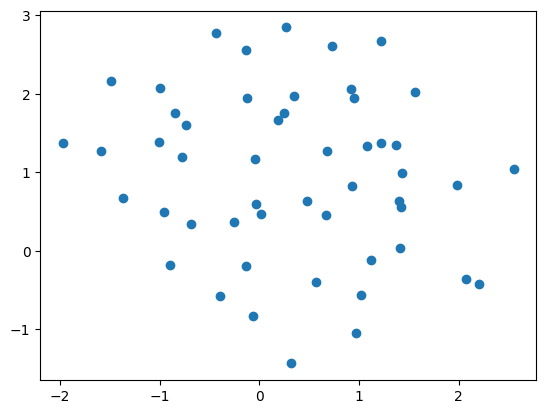

In [182]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Redução de dimensionalidade
tsne = TSNE(n_components=2, random_state=0, init="random")
X_embedded = tsne.fit_transform(model_sparse)

# Visualização
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.show()

In [ ]:
del df_consumidores, df_model, df_model_pivot, df_tratamentos, df_tratamentos_produtos, distances, f, sugestions, i, ids_tratametnos, model, model_sparse, 